<a href="https://colab.research.google.com/github/csy99/dna-nn-theory/blob/master/lstm_(supervised)_UCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from itertools import product
import re
import time
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow import keras

# Read Data

In [2]:
!pip install PyDrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def convert_label(row):
  if row["Classes"] == 'EI':
    return 0
  if row["Classes"] == 'IE':
    return 1
  if row["Classes"] == 'N':
    return 2

In [4]:
data_path = '/content/gdrive/My Drive/Colab Notebooks/UCI/'
splice_df = pd.read_csv(data_path + 'splice.data', header=None)
splice_df.columns = ['Classes', 'Name', 'Seq']
splice_df["Seq"] = splice_df["Seq"].str.replace(' ', '').str.replace('N', 'A').str.replace('D', 'T').str.replace('S', 'C').str.replace('R', 'G')
splice_df["Label"] = splice_df.apply(lambda row: convert_label(row), axis=1)
print('The shape of the datasize is', splice_df.shape)
splice_df.head()

The shape of the datasize is (3190, 4)


,Classes,Name,Seq,Label
0,EI,ATRINS-DONOR-521,CCAGCTGCATCACAGGAGGCCAGCGAGCAGGTCTGTTCCAAGGGCC...,0
1,EI,ATRINS-DONOR-905,AGACCCGCCGGGAGGCGGAGGACCTGCAGGGTGAGCCCCACCGCCC...,0
2,EI,BABAPOE-DONOR-30,GAGGTGAAGGACGTCCTTCCCCAGGAGCCGGTGAGAAGCGCAGTCG...,0
3,EI,BABAPOE-DONOR-867,GGGCTGCGTTGCTGGTCACATTCCTGGCAGGTATGGGGCGGGGCTT...,0
4,EI,BABAPOE-DONOR-2817,GCTCAGCCCCCAGGTCACCCAGGAACTGACGTGAGTGTCCCCATCC...,0


In [5]:
seq_num = 0
for seq in splice_df["Seq"]:
  char_num = 0
  for char in seq:
    if char != 'A' and char != 'C' and char != 'T' and char != 'G':
      print("seq", seq_num, 'char', char_num, 'is', char)
    char_num += 1
  seq_num += 1

In [6]:
# check if the length of the sequence is the same 
seq_len = len(splice_df.Seq[0])
print("The length of the sequence is", seq_len)
for seq in splice_df.Seq[:200]:
  assert len(seq) == seq_len

The length of the sequence is 60


In [7]:
xtrain_full, xtest, ytrain_full, ytest = train_test_split(splice_df, splice_df.Label, test_size=0.2, random_state=100, stratify=splice_df.Label)
xtrain, xval, ytrain, yval = train_test_split(xtrain_full, ytrain_full, test_size=0.2, random_state=100, stratify=ytrain_full)
print("shape of training, validation, test set\n", xtrain.shape, xval.shape, xtest.shape, ytrain.shape, yval.shape, ytest.shape)

shape of training, validation, test set
 (2041, 4) (511, 4) (638, 4) (2041,) (511,) (638,)


In [8]:
word_size = 1
vocab = [''.join(p) for p in product('ACGT', repeat=word_size)]
word_to_idx = {word: i for i, word in enumerate(vocab)}
vocab_size = len(word_to_idx)
print('vocab_size:', vocab_size)
create1gram = keras.layers.experimental.preprocessing.TextVectorization(
  standardize=lambda x: tf.strings.regex_replace(x, '(.)', '\\1 '), ngrams=1
)
create1gram.adapt(vocab)

vocab_size: 4


In [9]:
def ds_preprocess(x, y):
  x_index = tf.subtract(create1gram(x), 2)
  return x_index, y

In [ ]:
# not sure the correct way to get mapping from word to its index
create1gram('A C G T') - 2

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([3, 2, 1, 0])>

In [10]:
BATCH_SIZE = 256
xtrain_ds = tf.data.Dataset.from_tensor_slices((xtrain['Seq'], ytrain)).map(ds_preprocess).batch(BATCH_SIZE)
xval_ds = tf.data.Dataset.from_tensor_slices((xval['Seq'], yval)).map(ds_preprocess).batch(BATCH_SIZE)
xtest_ds = tf.data.Dataset.from_tensor_slices((xtest['Seq'], ytest)).map(ds_preprocess).batch(BATCH_SIZE)

In [11]:
latent_size = 30

model = keras.Sequential([
    keras.Input(shape=(seq_len,)),
    keras.layers.Embedding(seq_len, latent_size),
    keras.layers.LSTM(latent_size, return_sequences=False),
    keras.layers.Dense(128, activation="relu", input_shape=[latent_size]),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation="relu"),    
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation="relu"),  
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(16, activation="relu"), 
    keras.layers.Dropout(0.2),   
    keras.layers.Dense(3, activation="softmax")                                
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 60, 30)            1800      
_________________________________________________________________
lstm (LSTM)                  (None, 30)                7320      
_________________________________________________________________
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

In [12]:
es_cb = keras.callbacks.EarlyStopping(patience=400, restore_best_weights=True)
model.compile(keras.optimizers.SGD(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
hist = model.fit(xtrain_ds, validation_data=xval_ds, epochs=5000, callbacks=[es_cb])

流式输出内容被截断，只能显示最后 5000 行内容。
8/8 [==============================] - 0s 54ms/step - loss: 1.0249 - accuracy: 0.5189 - val_loss: 1.0255 - val_accuracy: 0.5186
Epoch 159/5000
8/8 [==============================] - 0s 58ms/step - loss: 1.0252 - accuracy: 0.5189 - val_loss: 1.0255 - val_accuracy: 0.5186
Epoch 160/5000
8/8 [==============================] - 0s 57ms/step - loss: 1.0259 - accuracy: 0.5189 - val_loss: 1.0255 - val_accuracy: 0.5186
Epoch 161/5000
8/8 [==============================] - 0s 57ms/step - loss: 1.0269 - accuracy: 0.5189 - val_loss: 1.0255 - val_accuracy: 0.5186
Epoch 162/5000
8/8 [==============================] - 0s 57ms/step - loss: 1.0250 - accuracy: 0.5189 - val_loss: 1.0254 - val_accuracy: 0.5186
Epoch 163/5000
8/8 [==============================] - 0s 55ms/step - loss: 1.0248 - accuracy: 0.5189 - val_loss: 1.0254 - val_accuracy: 0.5186
Epoch 164/5000
8/8 [==============================] - 0s 56ms/step - loss: 1.0265 - accuracy: 0.5189 - val_loss: 1.0254 - val_accu

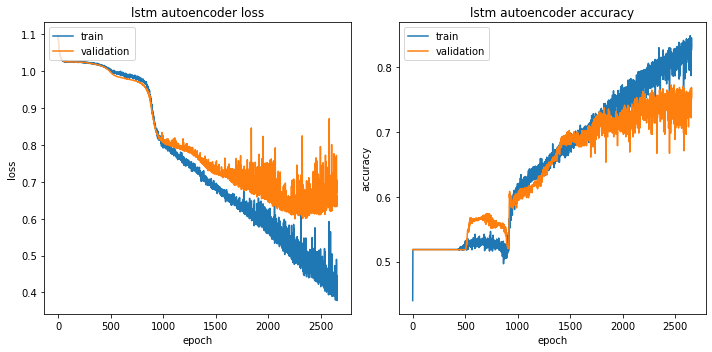

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i in range(1):
  ax1 = axes[0]
  ax2 = axes[1]

  ax1.plot(hist.history['loss'], label='training')
  ax1.plot(hist.history['val_loss'], label='validation')
  ax1.set_title('lstm autoencoder loss')
  ax1.set_xlabel('epoch')
  ax1.set_ylabel('loss')
  ax1.legend(['train', 'validation'], loc='upper left')
  
  ax2.plot(hist.history['accuracy'], label='training')
  ax2.plot(hist.history['val_accuracy'], label='validation')
  ax2.set_title('lstm autoencoder accuracy')
  ax2.set_xlabel('epoch')
  ax2.set_ylabel('accuracy')
  ax2.legend(['train', 'validation'], loc='upper left')
fig.tight_layout()

In [14]:
def eval_model(model, ds, ds_name="Training"):
  loss, acc = model.evaluate(ds, verbose=0)
  print("{} Dataset: loss = {} and acccuracy = {}%".format(ds_name, np.round(loss, 3), np.round(acc*100, 2)))

In [15]:
eval_model(model, xtrain_ds, "Training")
eval_model(model, xval_ds, "Validation")
eval_model(model, xtest_ds, "Test")

Training Dataset: loss = 0.438 and acccuracy = 82.12%
Validation Dataset: loss = 0.6 and acccuracy = 75.54%
Test Dataset: loss = 0.504 and acccuracy = 77.9%
